In [22]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers.core import Reshape
from sklearn.metrics import confusion_matrix

fetching the data



In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


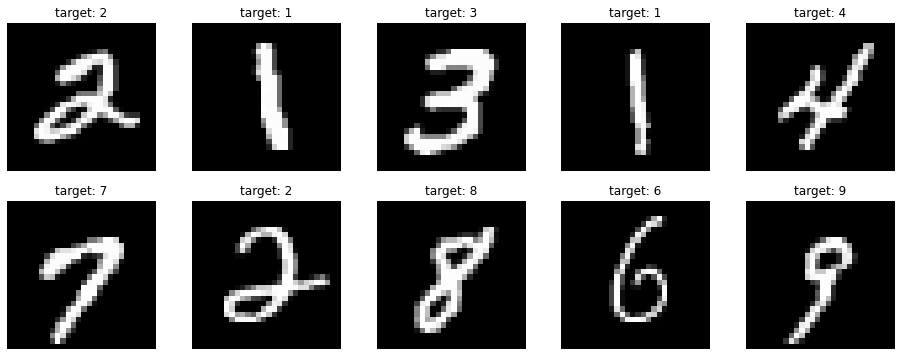

In [3]:
#Viewing the sample images in training datasets:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %5].imshow(X_train[i].reshape((28,28)), cmap='gray');
    axes[i//10, i %5].axis('off')
    axes[i//10, i %5].set_title(f"target: {y_train[i]}")

In [4]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
X_train, X_val = np.expand_dims(X_train, axis=-1), np.expand_dims(X_val, axis=-1)
y_train, y_val, true_val = to_categorical(y_train, num_classes=10), to_categorical(y_val, num_classes=10), y_val

In [5]:

gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

gen.fit(X_train)

Build network

In [7]:
def neuralnet():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), padding="Same", activation="relu", input_shape=(28,28,1)))
  model.add(Conv2D(filters=32, kernel_size=(5,5), padding="Same", activation="relu"))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=63, kernel_size=(3, 3), padding="Same", activation="relu"))
  model.add(Conv2D(filters=63, kernel_size=(3, 3), padding="Same", activation="relu"))
  model.add(MaxPool2D((2,2), strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="softmax"))
  model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer='sgd')
  print(model.summary())

  return model

In [8]:
model = neuralnet()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 63)        18207     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 63)        35784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 63)          0

Use Adaptive Learning rate

In [9]:
from keras.callbacks import ReduceLROnPlateau
adaptive_learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5,
                                           factor=0.5, min_lr=0.00001)

Fit Model

In [12]:
#hyperparameters:
num_epochs = 25
learning_rate = 0.1
batch_size = 32
step_per_echo = math.floor(X_train.shape[0]/batch_size)

In [14]:
pred = model.fit(gen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=step_per_echo, epochs=num_epochs, callbacks=[adaptive_learning_rate], validation_data=(X_val, y_val))

Epoch 1/25
1687/1687 [==============================] - 19s 12ms/step - loss: 0.5085 - accuracy: 0.8392 - val_loss: 0.1259 - val_accuracy: 0.9593
Epoch 2/25
1687/1687 [==============================] - 19s 11ms/step - loss: 0.3836 - accuracy: 0.8801 - val_loss: 0.0981 - val_accuracy: 0.9712
Epoch 3/25
1687/1687 [==============================] - 20s 12ms/step - loss: 0.3195 - accuracy: 0.9011 - val_loss: 0.1006 - val_accuracy: 0.9688
Epoch 4/25
1687/1687 [==============================] - 19s 11ms/step - loss: 0.2755 - accuracy: 0.9155 - val_loss: 0.0775 - val_accuracy: 0.9742
Epoch 5/25
1687/1687 [==============================] - 19s 11ms/step - loss: 0.2433 - accuracy: 0.9258 - val_loss: 0.0660 - val_accuracy: 0.9793
Epoch 6/25
1687/1687 [==============================] - 19s 12ms/step - loss: 0.2323 - accuracy: 0.9300 - val_loss: 0.0681 - val_accuracy: 0.9768
Epoch 7/25
1687/1687 [==============================] - 19s 11ms/step - loss: 0.2159 - accuracy: 0.9346 - val_loss: 0.0679 -

Plot of metrics[accuracy]

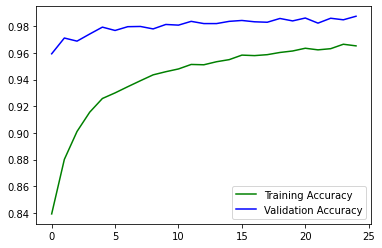

In [17]:
plt.plot(pred.history["accuracy"], 'g', label='Training Accuracy')
plt.plot(pred.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [19]:
pred_test = np.argmax(model.predict(X_val), axis=1)

In [20]:
#Confusion matrix
def plot_cm(true_y, pred_y):
  c_matrix = confusion_matrix(true_y, pred_y)
  plt.imshow(c_matrix, cmap='Accent')

  for i,j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > (c_matrix.max()/2.0) else "black")

  plt.title("Confusion Matrix")
  plt.ylabel("True values")
  plt.xlabel("Predicted values")

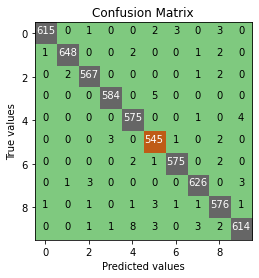

In [23]:
plot_cm(true_val, pred_test)